In [1]:
import numpy as np
import platform
import SarFileIO as sarIO
import cv2 as cv
import os
import scipy.io as scio
import osr
import ogr
import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import glob
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import math
import rasterio as rio
from osgeo import gdal, gdal_array
import os
import gdal2tiles

In [2]:
import tarfile
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np
from numpy import load
import scipy.io as scio

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [3]:
def Create_SAR_norm(sar_data):
    
    t11 = sar_data
   
    eps = 0.0000000000000001

    pb = 10 * np.log10(t11 + eps)
   

    maxpb=np.max(t11)
    minpb = np.min(t11)
    
    r = (pb - minpb) / (maxpb - minpb)
    r = np.clip(r, 0, 1)
    r = np.float32(255 * r)
   

    return r

In [4]:
def read_band_image(band, path):
    """
    This function takes as input the Sentinel-2 band name and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   band           string            Sentinel-2 band name
             path           string            path of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    a = path+'*B'+band+'*.jp2'
    img = gdal.Open(glob.glob(a)[0])
    data = np.array(img.GetRasterBand(1).ReadAsArray())
    spatialRef = img.GetProjection()
    geoTransform = img.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img.GetProjection())
    return data, spatialRef, geoTransform, targetprj

def nbr(band1, band2):
    """
    This function takes an input the arrays of the bands from the read_band_image
    function and returns the Normalized Burn ratio (NBR)
    input:  band1   array (n x m)      array of first band image e.g B8A
            band2   array (n x m)      array of second band image e.g. B12
    output: nbr     array (n x m)      normalized burn ratio
    """
    nbr = (band1 - band2) / (band1 + band2)
    return nbr

def dnbr(nbr1,nbr2):
    """
    This function takes as input the pre- and post-fire NBR and returns the dNBR
    input:  nbr1     array (n x m)       pre-fire NBR
            nbr2     array (n x m)       post-fire NBR
    output: dnbr     array (n x m)       dNBR
    """
    dnbr = nbr1 - nbr2
    return dnbr

def reproject_shp_gdal(infile, outfile, targetprj):
    """
    This function takes as input the input and output file names and the projection
    in which the input file will be reprojected and reprojects the input file using
    gdal
    input:  infile     string      input filename
            outfile    string      output filename
            targetprj              projection (output of function read_band_image)
    """
    ## reprojection with gdal 
    
    driver = ogr.GetDriverByName("ESRI Shapefile") 
    dataSource = driver.Open(infile, 1) # 0 means read-only. 1 means writeable.
    layer = dataSource.GetLayer()
    sourceprj = layer.GetSpatialRef()
    transform = osr.CoordinateTransformation(sourceprj, targetprj)
    
    # Create the output shapefile
    outDriver = ogr.GetDriverByName("Esri Shapefile")
    outDataSource = outDriver.CreateDataSource(outfile)
    outlayer = outDataSource.CreateLayer('', targetprj, ogr.wkbPolygon)
    outlayer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
    
    #Iterate over Features
    i = 0
    for feature in layer:
        transformed = feature.GetGeometryRef()
        transformed.Transform(transform) #reproject geometry

        geom = ogr.CreateGeometryFromWkb(transformed.ExportToWkb()) # create geometry from wkb (write geometry of reprojected geometry)
        defn = outlayer.GetLayerDefn() #layer definition
        feat = ogr.Feature(defn)  #create new feature
        feat.SetField('id', i) #set id
        feat.SetGeometry(geom) #set geometry
        outlayer.CreateFeature(feat) 
        i += 1
        feat = None
        
def array2raster(array, geoTransform, projection, filename):
    """ 
    This function tarnsforms a numpy array to a geotiff projected raster
    input:  array                       array (n x m)   input array
            geoTransform                tuple           affine transformation coefficients
            projection                  string          projection
            filename                    string          output filename
    output: dataset                                     gdal raster dataset
            dataset.GetRasterBand(1)                    band object of dataset
    
    """
    pixels_x = array.shape[1]
    pixels_y = array.shape[0]
    
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        filename,
        pixels_x,
        pixels_y,
        1,
        gdal.GDT_Float64, )
    dataset.SetGeoTransform(geoTransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()  # Write to disk.
    return dataset, dataset.GetRasterBand(1)  #If you need to return, remenber to return  also the dataset because the band don`t live without dataset.
 
def clip_raster(filename, shp):
    """
    This function clips a raster based on a shapefile
    input:  filename          string                input raster filename
            shp               dataframe             input shapefile open with geopandas
    output: clipped           array (1 x n x m)     clipped array 
            clipped_meta      dict                  metadata
            cr_ext            tuple                 extent of clipped data
            gt                tuple                 affine transformation coefficients
    """
    inraster = rasterio.open(filename)
    
    extent_geojson = mapping(shp['geometry'][0])
    clipped, crop_affine = mask(inraster, 
                                shapes=[extent_geojson], 
                                nodata = np.nan,
                                crop=True)
    clipped_meta = inraster.meta.copy()
    # Update the metadata to have the new shape (x and y and affine information)
    clipped_meta.update({"driver": "GTiff",
                 "height": clipped.shape[0],
                 "width": clipped.shape[1],
                 "transform": crop_affine})
    cr_ext = rasterio.transform.array_bounds(clipped_meta['height'], 
                                            clipped_meta['width'], 
                                            clipped_meta['transform'])
    
    # transform to gdal
    gt = crop_affine.to_gdal()
    
    return clipped, clipped_meta, cr_ext, gt
    
def reclassify(array):
    """
    This function reclassifies an array
    input:  array           array (n x m)    input array
    output: reclass         array (n x m)    reclassified array
    """
    reclass = np.zeros((array.shape[0],array.shape[1]))
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            if math.isnan(array[i,j]):
                reclass[i,j] = np.nan
            elif array[i,j] < 0.1:
                reclass[i,j] = 1
            elif array[i,j] < 0.27:
                 reclass[i,j] = 2
            elif array[i,j] < 0.44:
                 reclass[i,j] = 3
            elif array[i,j] < 0.66:
                 reclass[i,j] = 4
            else:
                reclass[i,j] = 5
                
    return reclass

In [5]:
def read_band_image(path,dronedata):
    """
    This function takes as input the ldrone image and the path of the 
    folder that the images are stored, reads the image and returns the data as
    an array
    input:   drone          drone image
             path           string            path ,of the folder
    output:  data           array (n x m)     array of the band image
             spatialRef     string            projection 
             geoTransform   tuple             affine transformation coefficients
             targetprj                        spatial reference
    """
    import os
    #img_ds = rio.open(r'T:\Aktive\DSU\3434\52232_Barkbilleskader_S_2\aux_data' + r'\dtm16m_utm32.tif')
    #img_ds1 = rio.open(path + dronedata)
    
    os.chdir(path)
    os.getcwd()
    #img_ds = gdal.Open(glob.glob(a)[0])
    img_ds = gdal.Open(dronedata, gdal.GA_ReadOnly)


    # gdal_rasterize -a HKL_VERDI -ot Float32 -of GTiff  -tr 20 20 -te 591964.4892070280620828 6607127.0049451533704996 609364.4892070280620828 6627967.0049451533704996  -l SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685 SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685.shp SKOGBRUKSPLAN_BESTAND_FLATE_0214_d5685_hklverdi.tif
    data = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                   gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

    for b in range(data.shape[2]):
        data[:, :, b] = np.array(img_ds.GetRasterBand(b + 1).ReadAsArray())


    
    spatialRef = img_ds.GetProjection()
    geoTransform = img_ds.GetGeoTransform()
    targetprj = osr.SpatialReference(wkt = img_ds.GetProjection())
    return data, spatialRef, geoTransform, targetprj

def ndvi(data):
    """
    This function takes an input the arrays of the bands from the read_band_image
    function and returns the NDVI
    input:  band1   array (n x m)      array of first band image e.g B1
            band2   array (n x m)      array of second band image e.g. B4
    output: ndvi     array (n x m)      normalized vegetation index
    """
    band1=data[:,:,4]
    band2=data[:,:,2]

    ndvi = (band1 - band2) / (band1 + band2)
    return ndvi

def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None,GeoT=None, Projection=None):
# If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name,Array.shape[2],Array.shape[1],Array.shape[0],DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name

In [6]:
def visRGB(img1, img2, img3,
           title = 'RGB image',
           scale1 = [],
           scale2 = [],
           scale3 = [],
           flag = 0, outall = ''):
    """
    Visualise the RGB of a single acquisition
    """           
    if scale1 == []:
       scale1 = img1
    if scale2 == []:
       scale2 = img2
    if scale3 == []:
       scale3 = img3

    size = np.shape(img1)           
    iRGB = np.zeros([size[0],size[1],3])
    iRGB[:,:,0] = np.abs(img1)/(np.abs(scale1).mean()*1.5)
    iRGB[:,:,1] = np.abs(img2)/(np.abs(scale2).mean()*1.5)
    iRGB[:,:,2] = np.abs(img3)/(np.abs(scale3).mean()*1.5)
    iRGB[np.abs(iRGB) > 1] = 1
            
#    plt.figure()

    fig = plt.figure(figsize=(8,8))
    ax2 = fig.add_subplot(1,1,1)
    plot = plt.imshow(iRGB); 
    plt.title('(RGB image'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

    if flag == 1:
        fig.savefig(outall)

    return       
           

In [7]:
dataset_path = '.\Patancheru'
sample_step = 64
sample_size = 128
year=2021
month='Jan'

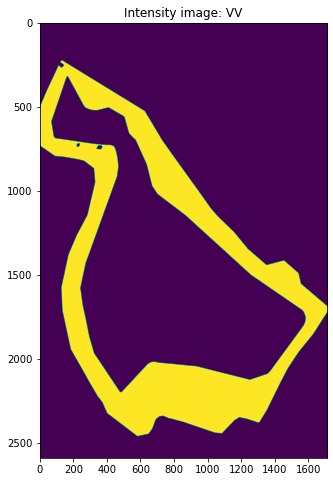

In [8]:
# Paths

if month=='Jan':
    path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Jan2021'
    inputfile='Orthomosaic_28Jan2021_PatanCheru_AOI_50cm.tif'
elif month=='Feb':
    path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Feb2021'
    inputfile='Orthomosaic_15Feb2021_PatanCheru_AOI_50cm.tif'
elif month=='Apr':
    path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Apr2021'
    inputfile='Orthomosaic_30Apr2021_PatanCheru_AOI_50cm.tif'

    
    
# Read drone bands 
(dronedata, crs, geoTransform, targetprj) = read_band_image(path,inputfile)

if month=='Apr':
    mask=dronedata[:,:,1]<65535
    
else:
    mask=dronedata[:,:,5]
    dronedata=dronedata[:,:,:5]
    
fig = plt.figure(figsize=(8,8))
plt.title("Intensity image: VV")
plt.imshow(mask)



In [9]:
dronedata.shape

(2591, 1710, 5)

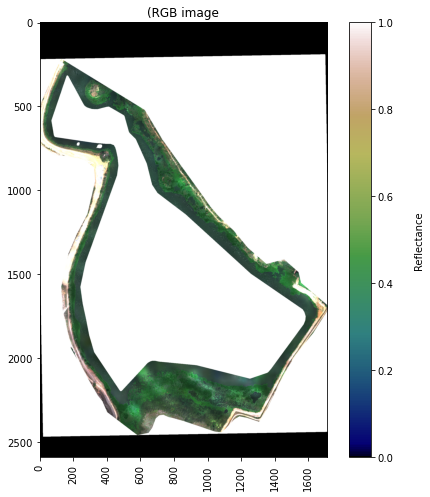

In [10]:
visRGB(dronedata[:,:,2], dronedata[:,:,1], dronedata[:,:,0],
           title = 'RGB image',
           scale1 = [0,20000],
           scale2 = [0,20000],
           scale3 = [0,15000],
           flag = 0, outall = '')

In [11]:
# Paths
if month=='Jan':
    path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Jan2021'
    inputfile='ICEYE_X7_GRD_SL_40871_20210129T074158_AOI.tif'
elif month=='Feb': 
    path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Feb2021'
    inputfile='ICEYE_X4_GRD_SL_41789_20210215T093026_AOI.tif'
elif month=='Apr': 
    path = r'C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Apr2021'
    inputfile='ICEYE_X2_GRD_SL_52808_20210430T163904_AOI.tif'

# Read drone bands 
(radardata, crs, geoTransform, targetprj) = read_band_image(path,inputfile)


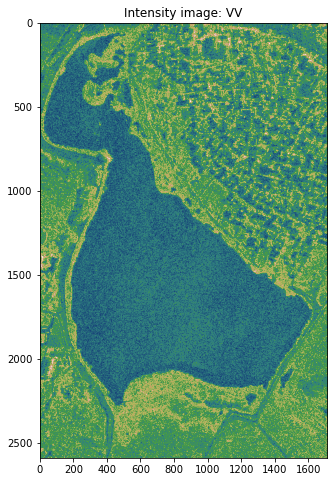

In [12]:
# Same for the VH
iRGBVV = np.abs(radardata)/(np.abs(radardata).mean()*2.5)
iRGBVV[np.abs(iRGBVV) > 1] = 1

# Now plot the RGB for VV
fig = plt.figure(figsize=(8,8))
plt.title("Intensity image: VV")
plt.imshow(iRGBVV)

In [13]:
def SampleCount(length):
    count = (length - sample_step) * 1.0 / sample_step
    count = int(count)
    return count

In [14]:
width = np.shape(dronedata)[1]
height = np.shape(dronedata)[0]
w_count = SampleCount(width)
h_count = SampleCount(height)
total_count =  w_count * h_count

tiles=[]
city_count = 0
for h_c in range(0,h_count):
    for w_c in range(0,w_count):
        h = h_c * sample_step
        w = w_c * sample_step
        sub_drone = dronedata[h:h + sample_size, w:w + sample_size,:5]
        sub_radar = radardata[h:h + sample_size, w:w + sample_size,:]
        #sub_mask = dronedata[h:h + sample_size, w:w + sample_size,5]
        #if month=='Apr':
        sub_mask = mask[h:h + sample_size, w:w + sample_size]
    

        #np.save(path + '/' + str(city_count), sub_drone,sub_radar,sub_mask)
        scio.savemat(path + '/' + str(city_count) +'.mat', {'drone': sub_drone, 'iceye': sub_radar, 'mask':sub_mask})
        city_count = city_count + 1
    

In [15]:
len(mask[mask>0])

871892

In [16]:
def load_images(path):    
    s1_list, s2_list,mask_list = list(), list(),list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        if filename.endswith('.mat'):
            #print(path + filename)
            pixels = scio.loadmat(path+'\\'+filename)
            s1_img, s2_img,mask_img = pixels['drone'],pixels['iceye'], pixels['mask']
            #print(s1_img.shape)
        
              
            if len(mask_img[mask_img>0])>mask_img.shape[0]*mask_img.shape[1]/1.01:
                s1_list.append(s1_img)
                s2_list.append(s2_img)
                mask_list.append(mask_img)

    return [asarray(s1_list), asarray(s2_list), asarray(mask_list)]

In [17]:
1/1.01

0.9900990099009901

In [18]:

# load dataset
[src_images, tar_images,mask_imsges] = load_images(path)
#src_images=src_images[:,:,:,:5]
print('Loaded: ', src_images.shape, tar_images.shape,mask_imsges.shape)
# save as compressed numpy array
filename = '\maps_'+str(sample_size)+'_'+month+str(year)+'.npz'
savez_compressed(path+filename, src_images, tar_images,mask_imsges)
print('Saved dataset drone & iceye:', path+filename)

Loaded:  (35, 128, 128, 5) (35, 128, 128, 1) (35, 128, 128)
Saved dataset drone & iceye: C:\Users\vaak\Desktop\UoS\weedwatch project\Transfer Learning\Test_GAN\Patancheru\Jan2021\maps_128_Jan2021.npz


Loaded:  (35, 128, 128, 5) (35, 128, 128, 1)
[ 8 26 29]


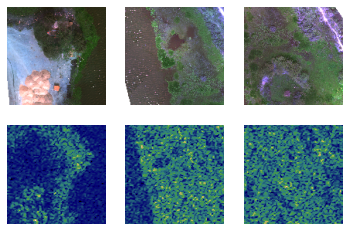

In [19]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
from numpy.random import randint


# load the dataset
data = load(path+filename)
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images

n_samples = 3

ix = randint(0, src_images.shape[0], n_samples)
print(ix)
    
for i in range(n_samples):
    srcim=src_images[i]
    size = np.shape(srcim)     # this function tell us the size of VV1, we need this 
    iRGB = np.zeros([size[0],size[1],3])    # create the 3D container
    iRGB[:,:,0] = np.abs(srcim[:,:,0])/(np.abs(srcim[:,:,0]).mean()*2.5)
    iRGB[:,:,1] = np.abs(srcim[:,:,1])/(np.abs(srcim[:,:,1]).mean()*2.5)
    iRGB[:,:,2] = np.abs(srcim[:,:,2])/(np.abs(srcim[:,:,2]).mean()*2.5)
    iRGB[np.abs(iRGB) > 1] = 1
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(iRGB)

# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(np.abs(tar_images[i])/(np.abs(tar_images[i]).mean()*2.5))
pyplot.show()



